In [1]:
import numpy
from matplotlib import pyplot as plt
from frc3223_azurite.motors import *
from frc3223_azurite.inertials import rod_about_end
from frc3223_azurite import motors
from frc3223_azurite.conversions import *
from frc971_controls import dplace, c2d
from profiler import TrapezoidalProfile

from arm import ArmSimulation

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, numpy.degrees(sim.thetas))
    if ylim is None:
        ylim = (-(180), (180))
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (deg)')
    plt.show()
    
def plot_velocity(sim, ylim =None):
    if ylim is None:
        ylim = (-(50), (500))
    plt.plot(sim.ts, numpy.degrees(sim.vs))
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (deg/s)')
    plt.show()
    
def plot_voltages(sim, ylim =None):
    if ylim is None:
        ylim = (-(.1), (1.10))
    plt.plot(sim.ts, sim.voltages)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('voltage')
    plt.show()
    
def clamp(x, xmin, xmax):
    return min(xmax, max(xmin, x))

In [2]:
DT = 0.01
Ng = 40
N = 2
motor_system=MotorSystem(motor=motors._775pro, motor_count=N, gearing_ratio=Ng)
motor = motors._775pro
r = motor.resistance()
kw = motor.kspeed()
kt = motor.ktorque()
j = inch_to_meter(16) ** 2 * lbs_to_kg(10)
print ("j: %f" % j)
print ('untrustworthy motor resistance: %f' % r)
Ac = numpy.matrix([[0, 1], [0,   -N * Ng * Ng * kw * kt / j / r]])
Bc = numpy.matrix([[0,], [N * Ng * kt / j / r]])
C = numpy.matrix([[1, 0]])

A, B = c2d(Ac, Bc, DT)
print ('continuous A:\n%s' % (Ac,))
print ('discrete A:\n%s' % (A,))
print ('continuous B:\n%s' % (Bc,))
print ('discrete B:\n%s' % (B,))

Kpoles = numpy.array([0.9, 0.9])
K = dplace(A, B, Kpoles)
print ('K: \n%s' % (K,))

Lpoles = numpy.array([0.9, -0.9])
L = dplace(A.T, C.T, Lpoles).T
print ('L: \n%s' % (L,))

dc_gain = - C * numpy.linalg.inv(Ac - Bc*K) * Bc
print("dc_gain: ", dc_gain)


j: 0.749170
untrustworthy motor resistance: 0.089552
continuous A:
[[ 0.          1.        ]
 [ 0.         -1.54618511]]
discrete A:
[[1.         0.00992309]
 [0.         0.98465707]]
continuous B:
[[0.        ]
 [6.31810218]]
discrete B:
[[0.00031428]
 [0.06269508]]
K: 
[[15.95021447  2.86536328]]
L: 
[[ 1.98465707]
 [16.0786189 ]]
dc_gain:  [[0.06269508]]


R: [[0.]]


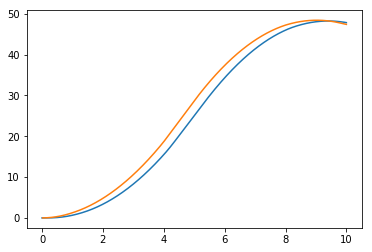

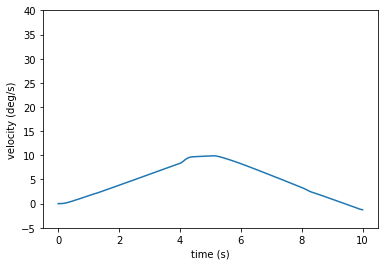

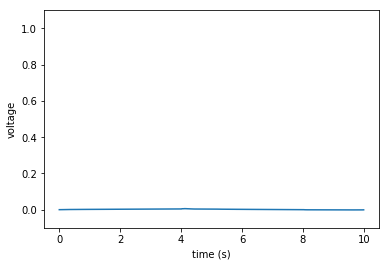

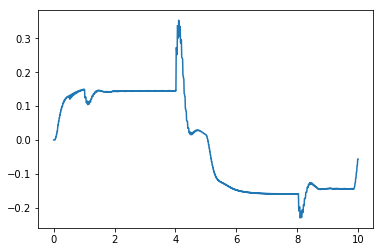

In [19]:
def r_for_position(theta_rad):
    #return numpy.matrix([[theta_rad / B[0, 0] ]])
    return numpy.matrix([[theta_rad / dc_gain[0, 0] ]])
    

def init(state):
    sim.state = state
    state.X_hat = numpy.matrix([[0,], [0,]])
    state.Y_hat = numpy.matrix([[0]])
    state.r_pos = 0
    state.t_poss = []
    state.r_poss = []
    state.R = r_for_position(numpy.radians(0))
    state.profiler = TrapezoidalProfile(
        cruise_v=numpy.radians(20), 
        a=numpy.radians(10), 
        target_pos=numpy.radians(45), 
        tolerance=numpy.radians(3))
    print ("R: %s" %((state.R),))

def periodic(state):
    X_hat_old = state.X_hat
    
    
    u = numpy.matrix(state.R - K * X_hat_old)[0, 0]
    u = clamp(u, -12, 12)
    #print ("U: %s" %(type(u),))
    #print("U: ", u.shape)
    #print("U: ", u[0,0])
    vp = u / sim.nominal_voltage
#     print("vp: %f" % vp)
    state.X_hat = A * X_hat_old + B * u + L * (state.theta_rad - C * X_hat_old)
    state.Y_hat = C * X_hat_old
    
    state.profiler.calculate_new_velocity(state.theta_rad, DT)
    state.r_pos += state.profiler.current_target_v * DT
    state.t_poss.append(state.time_from_start_s)
    state.r_poss.append(state.r_pos)
    state.R = r_for_position(state.r_pos)
    #print(state.Y_hat[0,0], state.theta_rad, state.X_hat[1, 0], state.velocity_radps)
    
    state.motor.set(vp)
    

sim = ArmSimulation(
    dt_s=0.001,
    starting_position_rad=numpy.radians(0),
    end_mass_kg=lbs_to_kg(10.3),
    arm_mass_kg=lbs_to_kg(.10),
    arm_length_m=inch_to_meter(16),
    nominal_voltage=12.,
    damping=0.001,
    periodic = periodic,
    #hardstop_spring_constant=100000,
    counterbalanced=True,
    init = init,
    motor_system=motor_system,
)
sim.run_sim(timeout=10., sample_rate=DT)

plt.plot(sim.ts, numpy.degrees(sim.thetas))
plt.plot(sim.state.t_poss, numpy.degrees(sim.state.r_poss))
plt.show()
plot_velocity(sim, ylim=(-5, 40))
plot_voltages(sim)
plt.plot(sim.ts, sim.currents)
plt.show()

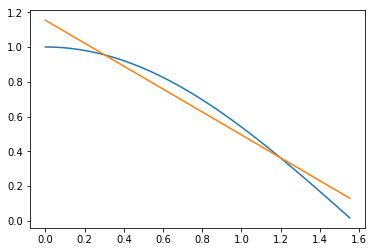

In [5]:
ts  = numpy.radians(range(0, 90))
vs = numpy.cos(ts)
import scipy
slope, th0, *stuff = scipy.stats.linregress(ts, vs)
plt.plot(ts, vs)
plt.plot(ts, ts * slope + th0)
plt.show()

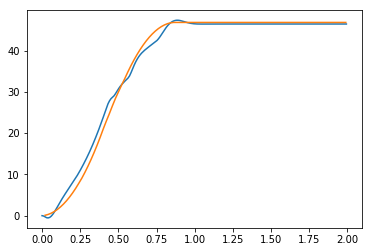

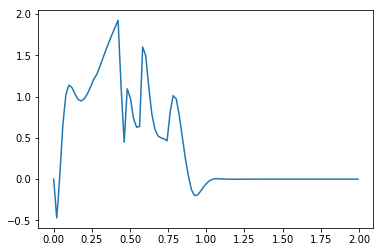

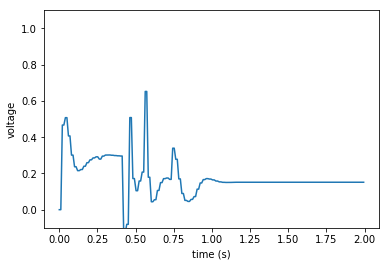

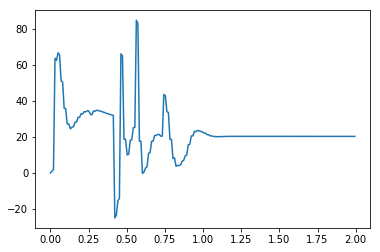

In [28]:
def give_up_use_pid():
    # I know, it's not a linear system
    from pidcontroller import NoThreadingPIDController as PIDController

    DT = 0.01
    Ng = 60
    N = 2
    motor_system=MotorSystem(motor=motors._775pro, motor_count=N, gearing_ratio=Ng)
    motor = motors._775pro
    r = motor.resistance()
    kw = motor.kspeed()
    kt = motor.ktorque()
    L = inch_to_meter(16)
    m = lbs_to_kg(10)
    j = L ** 2 * m + m * L ** 2 / 3.
    

    def init(state):
        from frc3223_azurite.conversions import g
        class ArmController(PIDController):
            def calculateFeedForward(self):
                a = self.a_goal
                v = self.v_goal
                th = self.pidInput.pidGet()
                
                c1 = N * Ng * kt / j / r / .9
                c2 = N * Ng * Ng * kt * kw / j / r
                gtorque = g * L * numpy.cos(th) * (m + lbs_to_kg(.10) ** 2 / 3)
                #print ('gga', gtorque)
                required_voltage = (j * a + gtorque + c2 * v) / c1
                available_voltage = sim.nominal_voltage
                x = required_voltage / available_voltage
                #print(x)
                return x
        sim.state = state
        state.pid = ArmController(Kp=3, Ki=0.0, Kd=10, 
                                  source=lambda: state.theta_rad, output=state.motor.set, period=DT)
        state.r_pos = state.theta_rad
        state.t_poss = []
        state.r_poss = []
        state.profiler = TrapezoidalProfile(
            cruise_v=numpy.radians(300), 
            a=numpy.radians(1000), 
            target_pos=numpy.radians(45), 
            tolerance=numpy.radians(3))
        
        state.pid.setSetpoint(state.theta_rad)
        state.pid.setInputRange(-180, 180)
        state.pid.setOutputRange(-1, 1)
        state.pid.enable()

    def periodic(state):
        state.profiler.calculate_new_velocity(state.theta_rad, DT)
        state.r_pos += state.profiler.current_target_v * DT
        state.t_poss.append(state.time_from_start_s)
        state.r_poss.append(state.r_pos)
        state.pid.a_goal = state.profiler.current_a
        state.pid.v_goal = state.profiler.current_target_v
        state.pid.setSetpoint(state.r_pos)
        state.pid._calculate()

    sim = ArmSimulation(
        dt_s=0.001,
        starting_position_rad=numpy.radians(0),
        end_mass_kg=lbs_to_kg(10.3),
        arm_mass_kg=lbs_to_kg(.10),
        arm_length_m=inch_to_meter(16),
        nominal_voltage=12.,
        damping=0.001,
        periodic = periodic,
        #hardstop_spring_constant=100000,
        counterbalanced=False,
        init = init,
        motor_system=motor_system,
    )
    sim.run_sim(timeout=2., sample_rate=DT)
    
    plt.plot(sim.ts, numpy.degrees(sim.thetas))
    plt.plot(sim.state.t_poss, numpy.degrees(sim.state.r_poss))
    plt.show()
    plt.plot(sim.ts, sim.vs)
    plt.show()
    plot_voltages(sim)
    plt.plot(sim.ts, sim.currents)
    plt.show()
    
give_up_use_pid()